## Text Classification - Natural Language Processing

Text classification also known as *text tagging* or *text categorization* is the process of categorizing text into organized groups. By using Natural Language Processing (NLP), text classifiers can automatically analyze text and then assign a set of pre-defined tags or categories based on its content.

This kernel aims to give  a brief overview of performing text classification using  Support Vector Machines and Random Forest. We will be using a dataset called "**Economic news article tone and relevance**" which consists of approximately 8000 news articles, which were tagged as ***relevant*** or ***not relevant*** to the US Economy. Our goal in this kernel is to explore the process of training and testing text classifiers for this dataset.

In [203]:
import numpy as np
import pandas as pd 

import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer 

import string
import re


from sklearn.svm import LinearSVC


from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn import metrics

from time import time

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv(r'/\US-Economic-News\US-Economic-News.csv', encoding='ISO-8859-1')
display(data.shape)


In [ ]:
data["relevance"].value_counts()

In [ ]:
data = data[data.relevance != "not sure"]
data.shape

In [ ]:
data["relevance"].value_counts()/data.shape[0] 

In [ ]:
fig = go.Figure([go.Bar(x=data['relevance'].value_counts().index, y=data['relevance'].value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

## Text Pre-processing

In [ ]:
data['relevance'] = data.relevance.map({'yes':1, 'no':0}) # relevant is 1, not-relevant is 0 
data = data[["text","relevance"]] # taking text input and output variable as relevance
data = data[:1000]
data.shape

In [ ]:
data.head()

In [ ]:
data['text'][0]

### Text Cleaning

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
import nltk
nltk.download('wordnet')
stopwords = ENGLISH_STOP_WORDS
lemmatizer = WordNetLemmatizer()

def clean(doc):
    text_no_namedentities = []
    document = nlp(doc)
    ents = [e.text for e in document.ents]
    for item in document:
        if item.text in ents:
            pass
        else:
            text_no_namedentities.append(item.text)
    doc = (" ".join(text_no_namedentities))

    doc = doc.lower().strip()
    doc = doc.replace("</br>", " ") 
    doc = doc.replace("-", " ") 
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])    
    doc = "".join([lemmatizer.lemmatize(word) for word in doc])
    return doc

In [ ]:
clean(data['text'][0])

In [ ]:
data['text'] = data['text'].apply(clean)
data.head()

In [215]:
docs = list(data['text'])
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000) 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)
docs = tfidf_vectorizer_vectors.toarray()

In [ ]:
X = docs 
y = data['relevance']
print(X.shape, y.shape)

In [ ]:
fig = go.Figure([go.Bar(x=y.value_counts().index, y=y.value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

### Train-Test Split

In [ ]:
SEED=123
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

## Support Vector Machines

In [ ]:
svc =  LinearSVC(class_weight='balanced') 
%time svc.fit(X_train, y_train)

y_pred_train = svc.predict(X_train)
y_pred_test = svc.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'], 
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant']))

In [ ]:
probs = svc._predict_proba_lr(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic - SVM')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier



rf_model = RandomForestClassifier(n_estimators=100,class_weight='balanced', random_state=SEED)


%time rf_model.fit(X_train, y_train)


y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)


print("Training Accuracy score:", accuracy_score(y_train, y_pred_train_rf))
print("Testing Accuracy score:", accuracy_score(y_test, y_pred_test_rf))


In [ ]:
print(classification_report(y_test, y_pred_test_rf, target_names=['not relevant', 'relevant']))

In [ ]:
cm = confusion_matrix(y_test, y_pred_test_rf)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'], 
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [ ]:
rf_probs = rf_model.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, rf_probs)
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)

plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(fpr_rf, tpr_rf, 'b', label = 'AUC = %0.2f' % roc_auc_rf)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## BERT Classifier

In [292]:
X_train,X_test,y_train,y_test = train_test_split(
    data['text'], 
    y, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=y
)


from transformers import pipeline

bert_classifier = pipeline("text-classification", model="bert-base-uncased", tokenizer="bert-base-uncased")
predictions = bert_classifier(X_test.tolist(), truncation=True)
pred_labels = [0 if pred['label'] == "yes" else 1 for pred in predictions]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


In [293]:
print(classification_report(y_test, pred_labels, target_names=['not relevant', 'relevant']))

              precision    recall  f1-score   support

not relevant       0.00      0.00      0.00       151
    relevant       0.24      1.00      0.39        49

    accuracy                           0.24       200
   macro avg       0.12      0.50      0.20       200
weighted avg       0.06      0.24      0.10       200



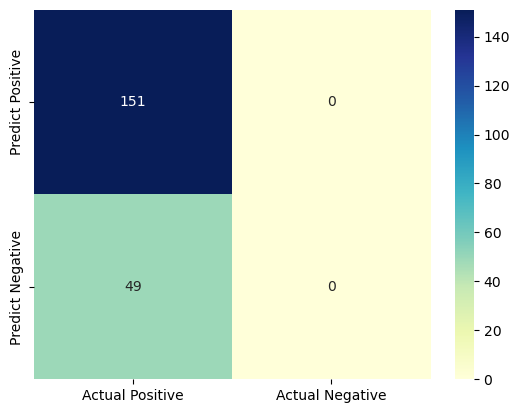

In [259]:
cm = confusion_matrix(y_test, pred_labels)


cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'], 
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()